# CAST
Collocated
Allong
Satellite
Track

### ToDo
- [x] read model data into a xarray dataset
- [x] read ADM data into a xarray dataset
- collocate model to ADM grid
  - [x] lon/lat
  - [x] time (not using right now)
  - [x] altitude/elevation
- example plot
  - [x] point plot for ADM/EMEP, per orbit
  - [x] scatterplot, per orbit
  - [x] curtain plots for ADM/EMEP, per orbit
  - [ ] plots for mean(bias)/RMSE/corr, per orbit

# Conda environment at PPI/lustre

```bash
# load right (ana)conda module
module load aerocom/anaconda3-stable

# use altair for plotting
source activate altair

# start notebook
jupyter lab --no-browser --ip=$HOSTNAME.met.no

```

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import altair as alt
from glob import glob

for m in [np, pd, xr, alt]:
    print(m.__name__, m.__version__)

numpy 1.14.2
pandas 0.23.4
xarray 0.10.8
altair 2.2.2


# Read NetCDF files
list the emep forecast and adm orbit files for a given date

In [2]:
lustre = '/lustre/storeB/project/fou/kl/admaeolus/%s'
archive = dict(
    emepmodel = lustre%'EMEPmodel/CWF_12ST-%Y%m%d_hourInst.nc',
    topomodel = lustre%'EMEP.topo/MACC14_topo_v1.nc',
    admaeolus = lustre%'data.rev.TD01/netcdf_emep_domain_mca/AE_TD01_ALD_U_N_2A_%Y%m%d*.DBL.nc',
)

date = pd.to_datetime('20180912')
ncfile = dict(
    emepmodel = date.strftime(archive['emepmodel']),
    topomodel = archive['topomodel'],
    admaeolus = glob(date.strftime(archive['admaeolus'])),
)

for k, v in ncfile.items():
    if isinstance(v, str):
        print(k, v)
    elif isinstance(v, list):
        for f in v:
            print(k, f)


emepmodel /lustre/storeB/project/fou/kl/admaeolus/EMEPmodel/CWF_12ST-20180912_hourInst.nc
topomodel /lustre/storeB/project/fou/kl/admaeolus/EMEP.topo/MACC14_topo_v1.nc
admaeolus /lustre/storeB/project/fou/kl/admaeolus/data.rev.TD01/netcdf_emep_domain_mca/AE_TD01_ALD_U_N_2A_20180912T130502027_005412000_000328_0002.DBL.nc
admaeolus /lustre/storeB/project/fou/kl/admaeolus/data.rev.TD01/netcdf_emep_domain_mca/AE_TD01_ALD_U_N_2A_20180912T160526028_005508009_000330_0002.DBL.nc
admaeolus /lustre/storeB/project/fou/kl/admaeolus/data.rev.TD01/netcdf_emep_domain_mca/AE_TD01_ALD_U_N_2A_20180912T143502034_005448001_000329_0002.DBL.nc
admaeolus /lustre/storeB/project/fou/kl/admaeolus/data.rev.TD01/netcdf_emep_domain_mca/AE_TD01_ALD_U_N_2A_20180912T020026032_012899990_000320_0002.DBL.nc
admaeolus /lustre/storeB/project/fou/kl/admaeolus/data.rev.TD01/netcdf_emep_domain_mca/AE_TD01_ALD_U_N_2A_20180912T070526030_005423993_000324_0002.DBL.nc
admaeolus /lustre/storeB/project/fou/kl/admaeolus/data.rev.TD0

## EMEP forecat
model `Z_MID` + `topography`

In [3]:
emep = xr.open_dataset(ncfile['emepmodel']).rename({"Z_MID":"alt"}).set_coords("alt")
if ncfile['topomodel']:
    topo = xr.open_dataset(ncfile['topomodel']).topography.isel(time=0)
    topo["lon"] = emep.lon
    topo["lat"] = emep.lat
    emep["alt"] += topo
    
# convert units: 1/m to 1/km
emep['EXT_350nm'] *= 1e3 # 1/m to 1e-3/m
emep['EXT_350nm'].attrs['units'] = "1/km"

emep

<xarray.Dataset>
Dimensions:         (bnds: 2, lat: 369, lev: 20, lon: 301, time: 25)
Coordinates:
  * lon             (lon) float64 -30.0 -29.75 -29.5 -29.25 -29.0 -28.75 ...
  * lat             (lat) float64 30.0 30.12 30.25 30.38 30.5 30.62 30.75 ...
  * lev             (lev) float64 0.1167 0.1528 0.1888 0.2271 0.2744 0.3362 ...
  * time            (time) datetime64[ns] 2018-09-12 2018-09-12T01:00:00 ...
    alt             (time, lev, lat, lon) float32 15562.683 15566.308 ...
Dimensions without coordinates: bnds
Data variables:
    lev_bnds        (lev, bnds) float64 ...
    ap              (lev) float64 ...
    b               (lev) float64 ...
    ap_bnds         (lev, bnds) float64 ...
    b_bnds          (lev, bnds) float64 ...
    AOD_350nm       (time, lat, lon) float32 ...
    AOD_DUST_350nm  (time, lat, lon) float32 ...
    AOD_SS_350nm    (time, lat, lon) float32 ...
    AOD_SIA_350nm   (time, lat, lon) float32 ...
    AOD_500nm       (time, lat, lon) float32 ...
    AOD_5

## ADM observations

In [4]:
adm = xr.open_dataset(ncfile['admaeolus'][6])

# convert units: 1/Mm to 1/km
adm['ec355aer'] *= 1e-3 # 1e-6/m to 1e-3/m
adm['ec355aer'].attrs['units'] = "1/km"

adm

<xarray.Dataset>
Dimensions:    (point: 1116)
Coordinates:
  * point      (point) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
Data variables:
    time       (point) datetime64[ns] ...
    ec355aer   (point) float64 0.001704 0.001986 0.003821 0.003605 0.004206 ...
    latitude   (point) float64 ...
    longitude  (point) float64 ...
    altitude   (point) float64 ...
Attributes:
    product:              AE_TD01_ALD_U_N_2A_20180912T053514029_005436007_000...
    proc_stage:           N
    ref_doc:              AE-IF-DLR-L2A-004 03.02
    acquisition_station:  Kiruna              
    proc_center:          Esrin 
    proc_time:            600337246.112
    software_ver:         ADM_L2Ap/3.7  
    baseline:              NaN                         
    sensing_start:        590045714.029983
    sensing_stop:         590051150.037429
    phase:                1
    cycle:                5
    rel_orbit:            769
    abs_orbit:            323
    state_vector_time:    59

# CAST

### Collocate lon, lat & time

In [5]:
collocate = lambda model, obs: model.load().sel(
    lon=obs.longitude,
    lat=obs.latitude,
#   alt=obs.altitude,
    time=obs.time,
    method='nearest'
)

%time emep = collocate(emep, adm)

emep.EXT_350nm

CPU times: user 1.16 s, sys: 200 ms, total: 1.36 s
Wall time: 1.87 s


<xarray.DataArray 'EXT_350nm' (point: 1116, lev: 20)>
array([[0.      , 0.001363, 0.001306, ..., 0.51636 , 0.555101, 0.721907],
       [0.      , 0.001363, 0.001309, ..., 0.538076, 0.578631, 0.744824],
       [0.      , 0.001356, 0.001282, ..., 1.073236, 0.56481 , 1.094823],
       ...,
       [0.      , 0.001207, 0.001766, ..., 0.163848, 0.20155 , 0.233826],
       [0.      , 0.001207, 0.001766, ..., 0.163848, 0.20155 , 0.233826],
       [0.      , 0.001207, 0.001766, ..., 0.163848, 0.20155 , 0.233826]],
      dtype=float32)
Coordinates:
    lon      (point) float64 24.25 24.0 24.0 24.0 24.0 24.0 24.0 24.0 23.75 ...
    lat      (point) float64 75.88 75.88 76.0 76.0 76.0 76.0 76.0 76.0 76.0 ...
  * lev      (lev) float64 0.1167 0.1528 0.1888 0.2271 0.2744 0.3362 0.4114 ...
    time     (point) datetime64[ns] 2018-09-12T06:00:00 2018-09-12T06:00:00 ...
    alt      (point, lev) float32 15048.066 13298.89 11920.635 10734.222 ...
  * point    (point) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13

### Collocate lev/alt

In [6]:
find_nearest = lambda arr, v: (np.abs(arr - v)).argmin()
find_level = lambda p: find_nearest(emep.alt.sel(point=p), adm.altitude.sel(point=p)).values

%time lev = xr.DataArray([find_level(p) for p in emep.point], dims='point', coords={'point':emep.point})
lev

CPU times: user 5.37 s, sys: 32 ms, total: 5.4 s
Wall time: 5.42 s


<xarray.DataArray (point: 1116)>
array([ 0,  0,  1, ..., 16, 17, 19])
Coordinates:
  * point    (point) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...

In [7]:
%time emep = emep.isel(lev=lev)

emep.EXT_350nm

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 2.88 ms


<xarray.DataArray 'EXT_350nm' (point: 1116)>
array([0.      , 0.      , 0.001356, ..., 0.123345, 0.163848, 0.233826],
      dtype=float32)
Coordinates:
    lon      (point) float64 24.25 24.0 24.0 24.0 24.0 24.0 24.0 24.0 23.75 ...
    lat      (point) float64 75.88 75.88 76.0 76.0 76.0 76.0 76.0 76.0 76.0 ...
    lev      (point) float64 0.1167 0.1167 0.1528 0.1888 0.2271 0.2744 ...
    time     (point) datetime64[ns] 2018-09-12T06:00:00 2018-09-12T06:00:00 ...
    alt      (point) float32 15048.066 15048.236 13296.555 11918.082 ...
  * point    (point) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
Attributes:
    long_name:           EXT_350nm
    units:               1/km
    class:               EXT:GROUP
    current_date_first:  [2018    9    1    0]
    numberofrecords:     1609
    current_date_last:   [2018   11    7    0]

# Plots

In [8]:
obs = adm.rename({
    'altitude':'alt','latitude':'lat','longitude':'lon','ec355aer':'ext_355'
}).set_coords(["time","lon","lat","alt"]).ext_355.to_dataframe()

mod = emep.rename({
    'EXT_350nm':'ext_355',
}).reset_coords("lev").ext_355.to_dataframe()

df = pd.concat({'obs':obs, 'mod':mod}, axis=1, names=["dataset"])
df.describe(percentiles=[.01, .05, .95, .99])

dataset          mod                                                  obs  \
                 lon          lat           alt      ext_355          lat   
count    1116.000000  1116.000000   1116.000000  1116.000000  1116.000000   
mean       10.568996    53.228271   6697.496582     0.031607    53.225049   
std         5.339017    13.552020   5041.067871     0.089507    13.548363   
min         3.750000    30.000000    132.559784     0.000000    30.022477   
1%          3.750000    30.000000    142.250312     0.000000    30.039601   
5%          4.187500    31.625000    492.185883     0.000000    31.622667   
50%         9.250000    53.625000   6006.619873     0.004423    53.627706   
95%        21.062500    73.750000  15448.190186     0.131044    73.725592   
99%        23.750000    76.000000  15623.241748     0.348416    75.950884   
max        24.250000    76.000000  15649.152344     1.332957    75.969865   

dataset                                         
                 lon           alt     ext_355  
count    1116.000000   1116.000000  912.000000  
mean       10.567043   6876.325258    0.027666  
std         5.337738   5386.988655    0.076161  
min         3.679784    156.164463    0.000080  
1%          3.741000    163.369993    0.000862  
5%          4.127843    533.954792    0.001608  
50%         9.309763   5969.760268    0.007021  
95%        21.077323  18555.426109    0.105344  
99%        23.784807  18571.434339    0.409990  
max        24.167454  18581.492351    0.963255

In [9]:
# tall table
df.stack('dataset').reset_index().to_json('cast_tall.json', orient="records")

# wide table
df = pd.merge(obs, mod, on='point', suffixes=('_obs', '_mod'))
df.reset_index().to_json('cast_wide.json', orient="records")

### Histogram
Up to 20 bins on log10 scale

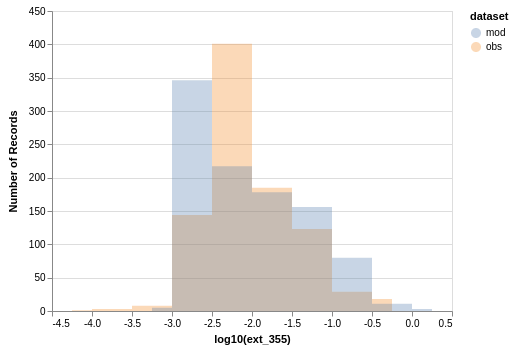

In [10]:
alt.Chart('cast_tall.json').mark_area(opacity=0.3, interpolate='step').encode(
    alt.X('ext_log10:Q', bin=alt.Bin(maxbins=20), title='log10(ext_355)'),
    alt.Y('count()', stack=None),
    color='dataset:N',
).transform_filter(
    alt.datum.ext_355 > 0
).transform_calculate(
    ext_log10 = 'log(datum.ext_355)/log(10)'
)

### Orbit/location Plots

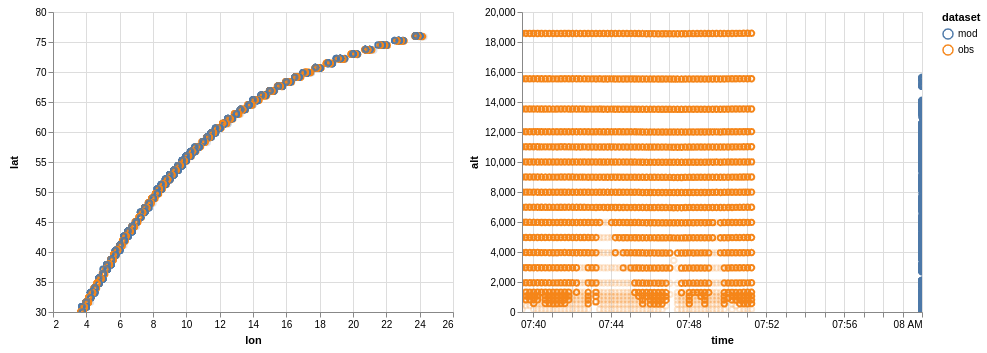

In [11]:
base = alt.Chart('cast_tall.json').encode(
    color='dataset:N',
    opacity=alt.condition((alt.datum.ext_355 <= 2) & (alt.datum.ext_355 > 0),  alt.value(1), alt.value(0.2)),
    tooltip=['point:O', 'time:T', 'lon:Q', 'lat:Q', 'alt:Q', 'ext_355:Q']
)

lonlat = base.mark_point().encode(
    alt.X('lon:Q', scale=alt.Scale(zero=False)),
    alt.Y('lat:Q', scale=alt.Scale(zero=False)),
).interactive()

timealt = base.mark_point().encode(
    x='time:T',
    y='alt:Q',
).interactive()

lonlat | timealt

### Orbit & Scatter Plots

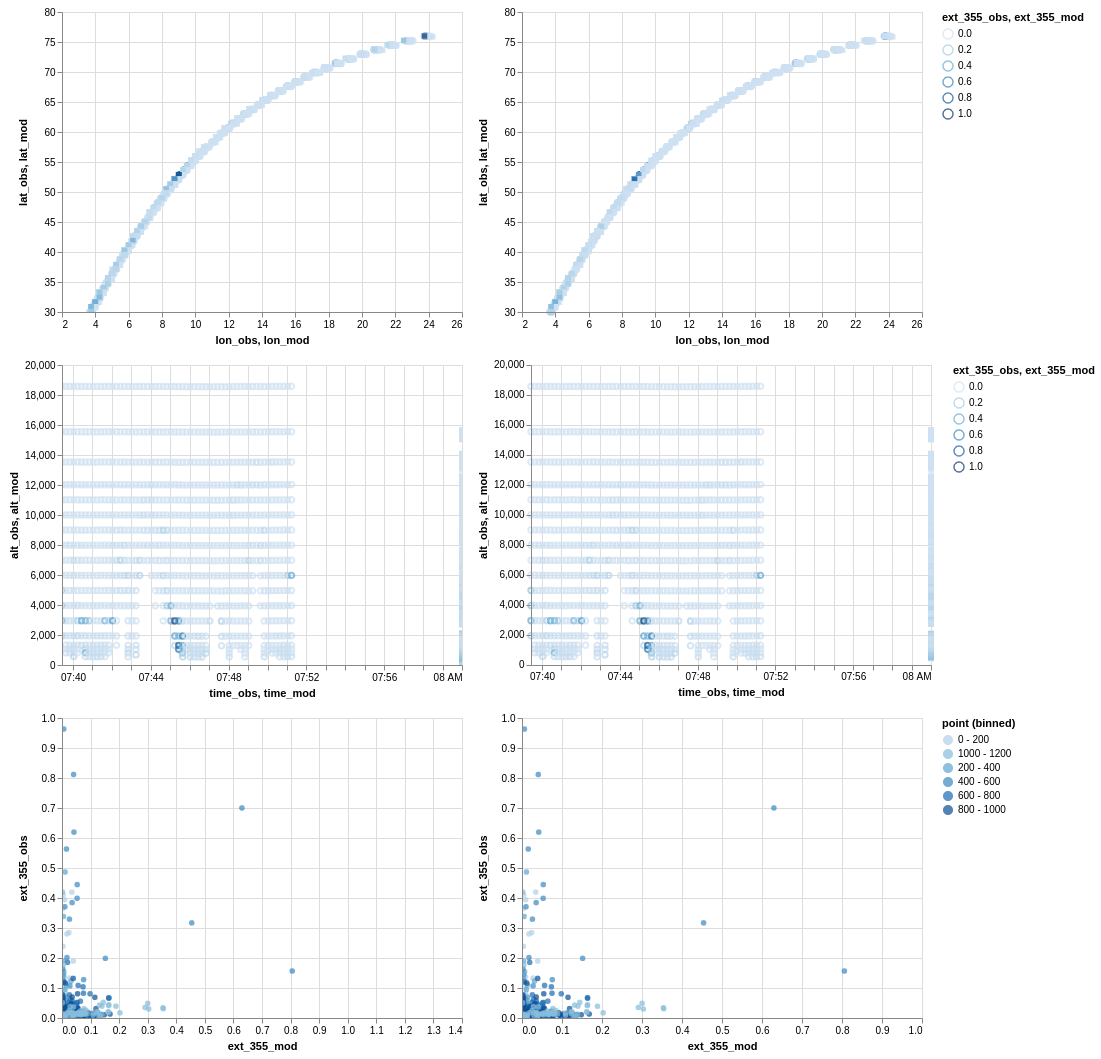

In [12]:
brush = alt.selection(type='interval', resolve='global')

base = alt.Chart('cast_wide.json').encode(
    color=alt.condition(brush, alt.Color('point:O', bin=alt.Bin(maxbins=10)), alt.value('lightgray')),
#   opacity=alt.condition((alt.datum.ext_355_obs <= 1) & (alt.datum.ext_355_obs > 0), alt.value(1), alt.value(0.2)),
)
obs = base.encode(
    color=alt.condition(brush, alt.Color('ext_355_obs:Q', scale=alt.Scale(domain=[0,1])), alt.value('lightgray')),
    tooltip=['point:O', 'time_obs:T', 'lon_obs:Q', 'lat_obs:Q', 'alt_obs:Q', 'ext_355_obs:Q']
)
mod = base.encode(
    color=alt.condition(brush, alt.Color('ext_355_mod:Q', scale=alt.Scale(domain=[0,1])), alt.value('lightgray')),
    tooltip=['point:O', 'time_mod:T', 'lon_mod:Q', 'lat_mod:Q', 'alt_mod:Q', 'ext_355_mod:Q']
)

lonlat_obs = obs.mark_point().encode(
    alt.X('lon_obs:Q', scale=alt.Scale(zero=False)),
    alt.Y('lat_obs:Q', scale=alt.Scale(zero=False)),
)
lonlat_mod = mod.mark_square().encode(
    alt.X('lon_mod:Q', scale=alt.Scale(zero=False)),
    alt.Y('lat_mod:Q', scale=alt.Scale(zero=False)),
)
lonlat = lonlat_obs + lonlat_mod.interactive()
lonlat_clean = lonlat_obs.transform_filter(
    alt.datum.ext_355_obs > 0
) + lonlat_mod.transform_filter(
    alt.datum.ext_355_obs > 0
).add_selection(
    brush
)

timealt_obs = obs.mark_point().encode(
    alt.X('time_obs:T'),
    alt.Y('alt_obs:Q', scale=alt.Scale(domain=[0,20e3])),
)
timealt_mod = mod.mark_square().encode(
    alt.X('time_mod:T'),
    alt.Y('alt_mod:Q', scale=alt.Scale(domain=[0,20e3])),
)
timealt = timealt_obs + timealt_mod.interactive()
timealt_clean = timealt_obs.transform_filter(
    alt.datum.ext_355_obs > 0
).add_selection(
    brush
) + timealt_mod.transform_filter(
    alt.datum.ext_355_obs > 0
)

scatter = base.mark_circle(clip=True).encode(
    y='ext_355_obs:Q',
    x='ext_355_mod:Q',
    tooltip=['point:O', 'time_obs:T', 'lat_obs:Q', 'alt_obs:Q', 'ext_355_obs:Q', 'ext_355_mod:Q',]
).add_selection(
    brush
)

scatter_clean = scatter.encode(
    alt.Y('ext_355_obs:Q', scale=alt.Scale(domain=[0,1])),
    alt.X('ext_355_mod:Q', scale=alt.Scale(domain=[0,1])),
).transform_filter(
    alt.datum.ext_355_obs > 0
)

( lonlat | lonlat_clean ) & (timealt | timealt_clean) & ( scatter | scatter_clean)

### Curtain plots

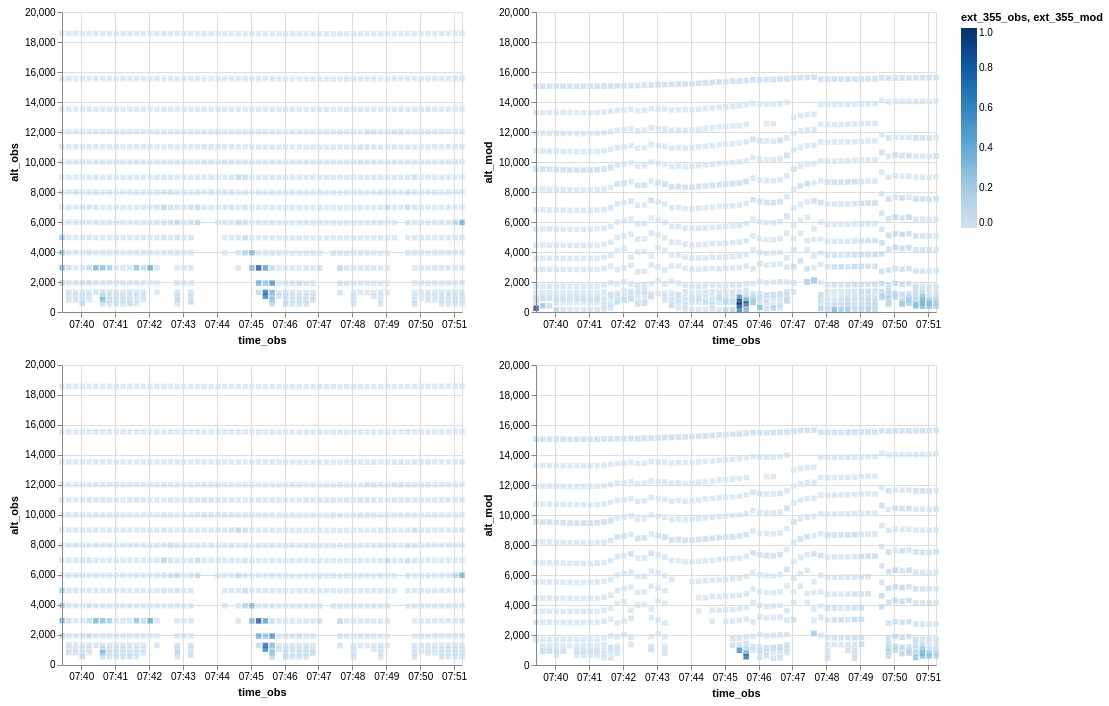

In [13]:
curtain_obs = base.mark_square().encode(
    alt.X('time_obs:T'),
    alt.Y('alt_obs:Q', scale=alt.Scale(domain=[0,20e3])),
    color=alt.condition(brush, alt.Color('ext_355_obs:Q', scale=alt.Scale(domain=[0,1])), alt.value('lightgray')),
    tooltip=['point:O', 'time_obs:T', 'alt_obs:Q', 'ext_355_obs:Q']
).add_selection(
    brush
)

curtain_mod = base.mark_square().encode(
    alt.X('time_obs:T'),
    alt.Y('alt_mod:Q', scale=alt.Scale(domain=[0,20e3])),
    color=alt.condition(brush, alt.Color('ext_355_mod:Q', scale=alt.Scale(domain=[0,1])), alt.value('lightgray')),
    tooltip=['point:O', 'time_mod:T', 'alt_mod:Q', 'ext_355_mod:Q']
).add_selection(
    brush
)

curtain_obs_clean = curtain_obs.transform_filter(
    (alt.datum.ext_355_obs <= 1) & (alt.datum.ext_355_obs > 0)
)

curtain_mod_clean = curtain_mod.transform_filter(
    (alt.datum.ext_355_obs <= 1) & (alt.datum.ext_355_obs > 0)
)

( curtain_obs | curtain_mod ) & ( curtain_obs_clean | curtain_mod_clean )